## 環境準備

In [1]:
!pip install  numpy pandas nltk sklearn pyprind

import time
import re
import pandas as pd
import numpy as np

In [65]:
from IPython.display import Image

# 目次

- 復習 勾配降下法
- さらに大規模なデータ処理：オンラインアルゴリズムとアウトオブコア学習
- トピックモデルの構築
  - 潜在ディリクレ配分を使ってテキスト文書を分解する
  - sckit-learnによる実装
- まとめ

  #  ◯復習 (2.5~2.6章)

## 勾配降下法
- 最急勾配降下法(バッチ勾配降下法)
- <span style="color: red; ">確率的勾配降下法(オンライン勾配降下法)</span>

$$(コスト関数)  = J(\theta) = \frac{1}{2}\sum_{i}(f_{\theta}(x^{(i)})-y^{(i)})^2$$

コスト関数が最小になるような、重み(係数)パラメータを探索する

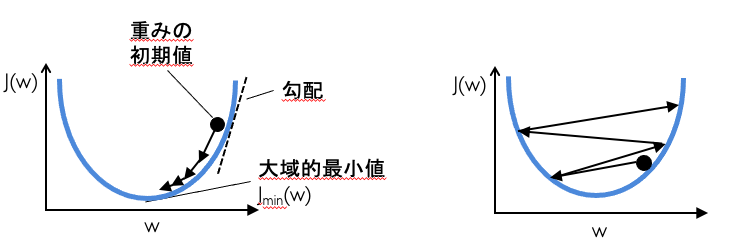

In [3]:
Image(filename='./images/08_01.png', width=600) 

### 通常の最急勾配降下法とは、、線形回帰を例に　(復習)

$$\theta_j := \theta_j - \eta \sum_{i=1}^n \Biggl(f_{\theta}(x^{(i)})-y^{(i)}\Biggr)x^{(i)}_j$$

#### 学習データのすべての誤差の合計を取ってからパラメーターを更新する
→学習データが多いと**計算コストが大きくなる**

→学習データが増える度に**全ての**学習データを使った再学習が必要

### 確率的勾配降下法

$$\theta_j := \theta_j - \eta \Biggl(f_{\theta} (x^{(k)}) - y^{(k)}\Biggr){x^{(k)}_j}$$
$$ k :パラメーター更新毎にランダムに選ばれたインデックス $$

### ミニバッチ勾配降下法

$$\theta_j := \theta_j - \eta \sum_{k\in K} \Biggl(f_{\theta}(x^{(k)}) - y^{(k)}\Biggr)x^{(k)}_j$$

$$K = 指定した個数のランダムなインデックスの集合$$

ミニバッチ勾配降下法は最急降下法と確率的勾配降下法の**中間**を取ったような形

最急降下法では時間がかかりすぎ、確率的勾配降下法では一つ一つのデータに揺さぶられることになる。(特に外れ値)

そのため、学習データの中からランダムにいくつかのデータを取り出して誤差を計算、パラメーターを更新する。

このときの一回に取り出すデータの数を**バッチサイズ**と呼ぶ

### 視覚的な図

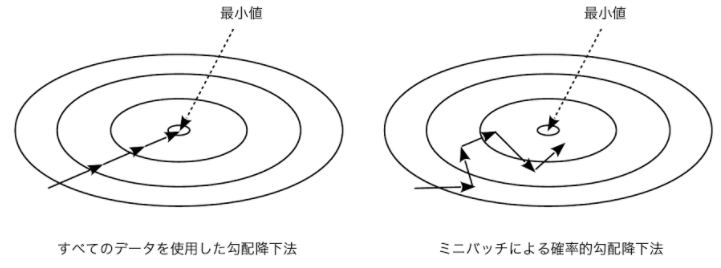

In [4]:
Image(filename='./images/08_02.png', width=600) 

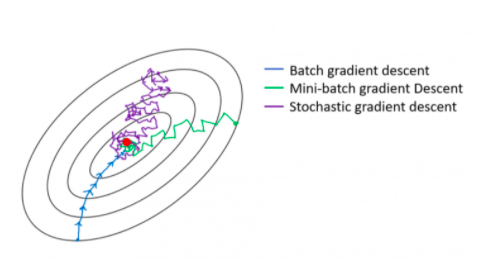

In [4]:
Image(filename='./images/08_03.png', width=600)

### マトリックス図

In [5]:
matrix = np.array([["訓練データの全てを利用","大", "安定", "小"],
                              ["訓練データの一部を利用","中間", "中間", "中間"],
                              ["1つのデータを利用","小(メモリ消費量小)", "不安定", "大"]])

df_matrix = pd.DataFrame(matrix,
                  columns=['利用するデータ量', '計算量', '勾配降下の安定', '外れ値の影響'],
                  index=['最急降下法(バッチ降下法)', 'ミニバッチ勾配降下法', '確率的勾配降下法'])

df_matrix

,利用するデータ量,計算量,勾配降下の安定,外れ値の影響
最急降下法(バッチ降下法),訓練データの全てを利用,大,安定,小
ミニバッチ勾配降下法,訓練データの一部を利用,中間,中間,中間
確率的勾配降下法,1つのデータを利用,小(メモリ消費量小),不安定,大


#### <div style="text-align: right;">[それぞれの収束の様子](https://sinhrks.hatenablog.com/entry/2014/11/24/205305)</div>

文献や記事によってはミニバッチ勾配降下法もまとめて確率的勾配降下法と記載している。

その他、確率的勾配降下法は勾配降下が不安定であるからこそ、
データによっては局所解に陥りづらいというメリットもある。 [詳細](https://axa.biopapyrus.jp/deep-learning/gradient_descent_method.html)

In [3]:
df = pd.read_csv('./movie_data.csv', encoding='utf-8')
df.head(5)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [4]:
#reviewの1行目(index = 0)を確認
df["review"][0]

'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich famil

In [5]:
df.shape

(50000, 2)

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ikutataiki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

<br>

### 文書を分類するロジスティックモデルの訓練

In [31]:
#実行の必要なし

# from sklearn.model_selection import train_test_split　も可。 stratify で割合を決められる。

#train, testの手動分割
X_train = df.loc[:25000, 'review'].values
y_train = df.loc[:25000, 'sentiment'].values
X_test = df.loc[25000:, 'review'].values
y_test = df.loc[25000:, 'sentiment'].values

### 8.2での出力の再確認

In [29]:
#参考出力　
## gs_lr_tfidf.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
/Users/sebastian/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 24.2min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed: 41.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=False,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [30]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10.0, 'clf__penalty': 'l2', 'vect__ngram_range': (1, 1), 'vect__stop_words': None, 'vect__tokenizer': <function tokenizer at 0x7fbc89ae1ea0>} 
CV Accuracy: 0.897


In [31]:
clf = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf.score(X_test, y_test))

Test Accuracy: 0.899


<br>
<br>

# 8.3 大規模なデータ処理：オンラインアルゴリズムとアウトオブコア学習

### 目的
1. 8.2 で行った映画レビューセットのロジスティック回帰分類(肯定的 or 否定的)をアウトオブコア学習にて行う。
2. 1.の結果をバッチ学習と比べ、学習の速度と精度がどのように変化するかを確認する。

In [57]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

# 文書のクレンジングとストップワードの除去を行う
def tokenizer(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop] #ストップワード
    return tokenized

# ジェネレータ関数の定義 ストリーミング用
def stream_docs(path):
    with open(path, 'r', encoding='utf-8') as csv:
        next(csv)  # ヘッダーを読み飛ばす
        for line in csv:
            text, label = line[:-3], int(line[-2])
            yield text, label #yieldで1つ1つ取得ができている

In [58]:
#ストリーミングできているかの確認
next(stream_docs(path='movie_data.csv'))

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [59]:
#指定数の文書を返す
def get_minibatch(doc_stream, size):
    docs, y = [], []
    try:
        for _ in range(size):
            text, label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None, None
    return docs, y

In [60]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier

vect = HashingVectorizer(decode_error='ignore',  #utf-8以外の文字エンコーディングが来てもエラーを返さないようにする。 {{‘strict’, ‘ignore’, ‘replace’}, default=’strict’}
                         n_features=2**21, #特徴量の総個数　2の累乗が一般的。大きいほど特徴量の衝突を防ぐが次元数が大きくなる。
                         preprocessor=None,   # default = None, 
                         tokenizer=tokenizer)

 ## HashingVectorizer

 CountVectrierは文書中の全ての語彙を読み込む必要があるため、オンライン学習時には使用できない。
 
 その代わりに語彙をメモリに保持しない**HashingVectorizer**を使用する
 
 [詳細](https://kavita-ganesan.com/hashingvectorizer-vs-countvectorizer/#.YZIdo73P1pQ)
 
 [HashingVectorizer公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html)

In [61]:
#確率的勾配降下法
clf = SGDClassifier(loss='log', random_state=1) #loss = 'log' -> ロジスティック回帰  loss = 'hinge' -> サポートベクターマシン

doc_stream = stream_docs(path='movie_data.csv')

[SGDClassifier 公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)

In [62]:
import pyprind
pbar = pyprind.ProgBar(45)

classes = np.array([0, 1])
for _ in range(45): #バッチサイズ1000　× ループ45回 = 45,000文書
    X_train, y_train = get_minibatch(doc_stream, size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train, y_train, classes = classes) #classesでy_trainの正解ラベルを指定
    pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:32


In [63]:
X_test, y_test = get_minibatch(doc_stream, size=5000)
X_test = vect.transform(X_test)
print('Accuracy: %.3f' % clf.score(X_test, y_test))

Accuracy: 0.868


trainデータ数が多く、グリッドサーチしていないため単純比較はできないが、精度も約87%と8.2の結果から3%ほど下回っている。
とはいえ、モデルのfitは1分未満で完了し、メモリ効率が大幅に改善されたといえる

<br>

## 8.4 潜在ディリクレ配分(Latent Dirichlet Allocation ; LDA)によるトピックモデルの構築

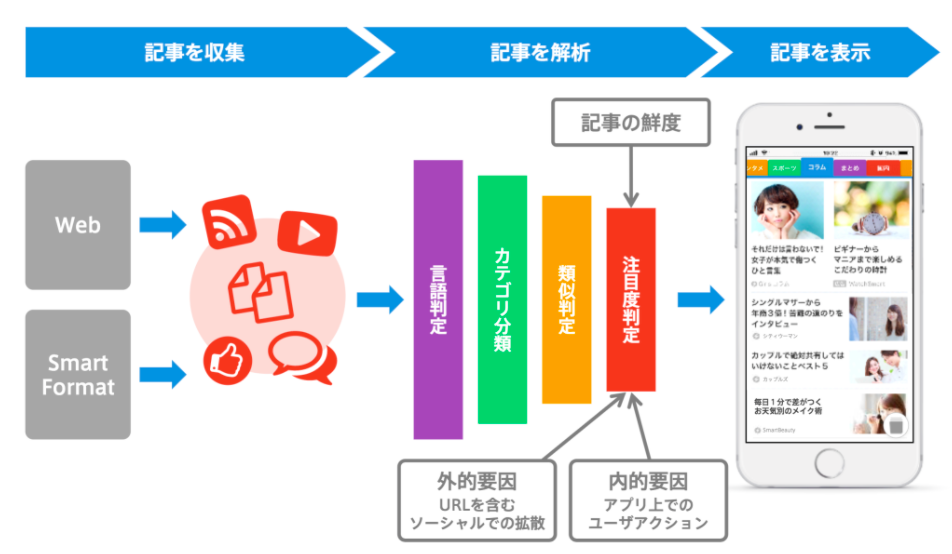

In [64]:
Image(filename='./images/08_04.png', width=600) 


### トピックモデル
ラベルなしのテキスト文書にトピックを割り当てる手法 \
    ex. 新聞などの記事の内容から、(スポーツ、経済、政治、エンタメ)などのカテゴリラベルを割り当てる

### 潜在ディリクレ配分(LDA)を使うと何ができるか

BoWによって表現された文書集合をより低次元のベクトルで表現

- 文書のカテゴリ分類 (→トピックモデルの推定)
- 類似した文書の検索 (論文検索) 
- 書いたレビュー等を元にレコメンドシステムへ反映

    トピック( = 文書集合に内在する話題)　毎に出現する、出現しやすい単語が異なる。
        ex. 野党、国民、選挙　などの単語が多ければ、政治についての記事である可能性が高い

実際に潜在ディリクレ配分(LDA)は、ベイズ推定を用いた数学的には複雑なアルゴリズムになる。
LDAは確率的生成モデルであり、さまざまな文書に同時に出現する一連の単語を見つけ出そうとする。
各文書をさまざまな単語が混在したものであるとすれば、そうした出現頻度の高い単語はその文書の特徴(トピック)を表す。

[潜在ディリクレ配分のグラフィカルモデル および数式の詳細説明 (Qiita)](https://qiita.com/K_Noguchi/items/2f0579ca51f5329a4008)

<br>

## 目的
8.1で使用した映画レビューセットを使用し、それらレビューはどのようなトピックになるかを確認する。

In [14]:
# LDAへの入力用 CountVectrizerによるBoWの生成
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', 
                        max_df=.1, # 単語の最大文書頻度を10%に設定 ニュースは?目安あるか　除去されてるワードは？
                        max_features=5000)  # 1トピックあたりの単語の個数を5,000個に制限
X = count.fit_transform(df['review'].values) 

#### ?? なぜ単語の最大文書頻度を10%にするか
・・・どの文書にも出現する単語は、(たとえ頻出であったとしても)そのトピックを特徴づける単語である可能性は低いから

#### ?? なぜ単語の最大個数を5,000個にするか
・・・データセットの次元を制限するため　　推定精度を向上させる

上記「max_df」,「max_features」はハイパーパラメータ。調整可能

#### メモ
max_featureを500にしたところ、固有名詞や年代など、あまり重要でないものも上位に来ている。

[CountVectrizer 公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)

In [15]:
# LDA をインポート
from sklearn.decomposition import LatentDirichletAllocation

#ldaインスタンス化 
lda = LatentDirichletAllocation(n_components=10, #トピック数 ←の場合10種類のトピック
                                random_state=123,
                                learning_method='batch')  # "batch"  <-> "online"学習 のときbatch_sizeintでバッチサイズ指定可能 default=128

start = time.time()
X_topics = lda.fit_transform(X) # fitに5~10分ほどかかる (Intel core i5)
end = time.time() - start
print(end)

550.856329202652


[ LatentDirichletAllocation公式ドキュメント](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation)

In [16]:
lda.components_.shape  # 10種類のトピック毎にそれぞれ単語の重要度(max_features = 5,000)を含んだ行列

(10, 5000)

In [17]:
lda.components_

array([[8.56125050e+01, 1.00410357e+02, 3.34310673e+02, ...,
        4.43957836e+02, 2.82516717e+02, 3.18565457e+01],
       [3.45989543e+01, 1.00950306e+01, 6.42071481e+01, ...,
        1.00004456e-01, 1.00003252e-01, 4.50346336e+00],
       [1.86415890e+01, 1.60992487e+02, 1.33738844e+02, ...,
        1.00010052e-01, 1.00011791e-01, 5.67732053e+00],
       ...,
       [1.15636336e-01, 1.87311009e+01, 1.19416651e+01, ...,
        1.00010921e-01, 1.00012775e-01, 1.96018293e+02],
       [7.50723350e+00, 2.03602735e+01, 5.44948271e+01, ...,
        1.00011303e-01, 1.00012372e-01, 1.22170789e-01],
       [1.00019748e-01, 3.26175729e+01, 1.07677240e+02, ...,
        1.00014323e-01, 1.00017673e-01, 3.04437584e+00]])

In [18]:
n_top_words = 5
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
worst minutes awful script stupid
Topic 2:
family mother father children girl
Topic 3:
american war dvd music tv
Topic 4:
human audience cinema art sense
Topic 5:
police guy car dead murder
Topic 6:
horror house sex girl woman
Topic 7:
role performance comedy actor performances
Topic 8:
series episode war episodes tv
Topic 9:
book version original read novel
Topic 10:
action fight guy guys cool


/Users/ikutataiki/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#### 各トピックにおいて最も重要な5つの単語から、LDAが次のトピックを特定したことがわかる:
    
1. Generally bad movies (全般的に評価の低い映画; 実際にはトピックカテゴリではない)
2. Movies about families
3. War movies
4. Art movies
5. Crime movies
6. Horror movies
7. Comedies
8. Movies somehow related to TV shows
9. Movies based on books
10. Action movies

To confirm that the categories make sense based on the reviews, let's plot 5 movies from the horror movie category (category 6 at index position 5):

In [19]:
horror = X_topics[:, 5].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print('\nHorror movie #%d:' % (iter_idx + 1))
    print(df['review'][movie_idx][:300], '...')


Horror movie #1:
House of Dracula works from the same basic premise as House of Frankenstein from the year before; namely that Universal's three most famous monsters; Dracula, Frankenstein's Monster and The Wolf Man are appearing in the movie together. Naturally, the film is rather messy therefore, but the fact that ...

Horror movie #2:
Okay, what the hell kind of TRASH have I been watching now? "The Witches' Mountain" has got to be one of the most incoherent and insane Spanish exploitation flicks ever and yet, at the same time, it's also strangely compelling. There's absolutely nothing that makes sense here and I even doubt there  ...

Horror movie #3:
<br /><br />Horror movie time, Japanese style. Uzumaki/Spiral was a total freakfest from start to finish. A fun freakfest at that, but at times it was a tad too reliant on kitsch rather than the horror. The story is difficult to summarize succinctly: a carefree, normal teenage girl starts coming fac ...


#### 実際にレビューがどの映画に属しているかはわからないが、確かにホラー映画のレビューのように見える
#### (ただし、最初の300文字だけみると＃2はトピックカテゴリ1(悪評価)に属する可能性があると思うかもしれない)

### おまけ　learning_method = 'online'で回してみる

In [45]:
lda = LatentDirichletAllocation(n_components=10, 
                                random_state=123,
                                learning_method='online') #'batch'→'online'に変更  batch_size = 128(default)

start = time.time()
X_topics = lda.fit_transform(X)
end = time.time() - start
print(end)

n_top_words = 5
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

323.8198471069336
Topic 1:
comedy fun humor jokes jack
Topic 2:
family mother woman father feel
Topic 3:
black men white city doctor
Topic 4:
action effects special guy game
Topic 5:
role plays played performance actor
Topic 6:
style music cinema audience screen
Topic 7:
horror killer house dead thriller
Topic 8:
series war book version episode
Topic 9:
dvd minutes video kids day
Topic 10:
worst script wasn boring maybe


In [46]:
horror = X_topics[:, 6].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print('\nHorror movie #%d:' % (iter_idx + 1))
    print(df['review'][movie_idx][:300], '...')


Horror movie #1:
How much can you really say about a condom with teeth? The plot was really out there, but it was something campy to see on a Friday night. The story has a lot of unexpected twists, and it's a great way to offend all you're conservative friends! ...

Horror movie #2:
College girl Joanne Murray takes on the unenviable job of readying the student housing building to become apartments,which includes selling the unneeded furniture This takes place during a break,so a mysterious psycho is stalking the nearly-empty premises on campus."Dorm that Dripped Blood" is a low ...

Horror movie #3:
An annoying group of ex-students from 'Monte Alto International High School' decide to spend a night in the now abandoned institution where a 'mystery' killer called the watchman played by horror legend Paul Naschy murders them off one by one."School Killer" features some references to such teen sla ...


### おまけ2 max_features = 1000で回してみる　

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english', 
                        max_df=.1, # 単語の最大文書頻度を10%に設定
                        max_features=1000)  # 1トピックあたりの単語の個数を5,000個に制限
X = count.fit_transform(df['review'].values)

In [51]:
from sklearn.decomposition import LatentDirichletAllocation

#ldaインスタンス化  引数に変更なし
lda = LatentDirichletAllocation(n_components=10, 
                                random_state=123,
                                learning_method='batch')  

start = time.time()
X_topics = lda.fit_transform(X)
end = time.time() - start
print(end)

502.57874584198


In [52]:
lda.components_.shape 

(10, 1000)

In [53]:
n_top_words = 5
feature_names = count.get_feature_names()

for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()\
                        [:-n_top_words - 1:-1]]))

Topic 1:
action original effects space fi
Topic 2:
book girl woman read ending
Topic 3:
worst minutes stupid terrible awful
Topic 4:
war game action guy episode
Topic 5:
performance role excellent performances actor
Topic 6:
series tv episode documentary episodes
Topic 7:
men women town black woman
Topic 8:
family children father mother son
Topic 9:
horror house blood gore dead
Topic 10:
comedy fun dvd ll watched


In [54]:
horror = X_topics[:, 8].argsort()[::-1]

for iter_idx, movie_idx in enumerate(horror[:3]):
    print('\nHorror movie #%d:' % (iter_idx + 1))
    print(df['review'][movie_idx][:300], '...')


Horror movie #1:
A demon, from a tree, removes itself in the form of a human man to make love to a young fair maiden only for her to die. The demon's eyes freeze, two drops of blood fall onto a bed he had specially created for his object of desire. The bed consumes the blood and it's hunger remains..anything that co ...

Horror movie #2:
OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop.OZ is the greatest show ever mad full stop ...

Horror movie #3:
I can honestly say that "Death Bed: The Bed That Eats" was a much better movie than I expected. Allow me to clarify the plot in case the title of the film is a little too vague - there is a bed that eats. An evil bed. It eats people. Several unsuspecting women on an "outing" of some kind, stumble ac ...


<br>
<br>

# まとめ

### ・アウトオブコア学習により、学習速度の向上が期待できた。
### ・LDAを使うことにより、様々な映画のレビューをトピック毎に分類ができた

<br>